In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [20]:
import warnings
warnings.filterwarnings("ignore")


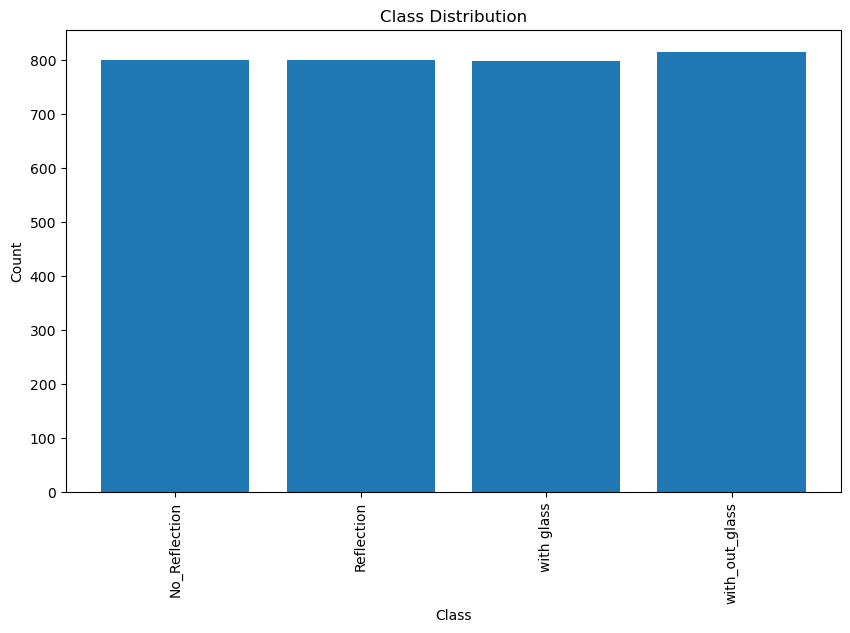

In [21]:
dataset_path = "C:\\Users\\yashu\\Downloads\\Desktop\\final year project\\training"

class_folders = os.listdir(dataset_path)

class_counts = {folder: len(os.listdir(os.path.join(dataset_path, folder))) for folder in class_folders}
class_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(class_df['Class'], class_df['Count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.xticks(rotation='vertical')

plt.show()


### glass no glass TRAINING

In [22]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    one_hot_labels = to_categorical(encoded_labels)
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    return one_hot_labels, label_mapping

def load_eye_data(folder_path, eye_labels, target_shape=(224, 224)):
    all_images = []
    all_eye_labels = []

    print("Loading and preprocessing data...")
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if label not in eye_labels:
            continue

        current_label = 1 if label == 'Reflection' else 0

        print(f"Processing images for label: {label}")

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            img_array = cv2.imread(file_path, cv2.IMREAD_COLOR)
            resized_img = cv2.resize(img_array, target_shape, interpolation=cv2.INTER_NEAREST)

            all_images.append(resized_img)
            all_eye_labels.append(current_label)

    print("Data loading and preprocessing complete.")
    return np.array(all_images), np.array(all_eye_labels)


folder_path = "C:\\Users\\yashu\\Downloads\\Desktop\\final year project\\training"

eye_labels = ['Reflection', 'No_Reflection']
images, eye_labels = load_eye_data(folder_path, eye_labels)

common_shape = (224, 224, 3)
images = np.array([cv2.resize(img, (common_shape[1], common_shape[0])) for img in images])

eye_encoded_labels, eye_label_mapping = encode_labels(eye_labels)

print("\nNumber of images for each class before train-test split:")
for class_label in np.unique(eye_encoded_labels):
    count = np.sum(eye_encoded_labels[:, 1] == class_label)
    print(f"Class {class_label}: {count} images")

eye_X_train, eye_X_test, eye_y_train, eye_y_test = train_test_split(images, eye_encoded_labels, test_size=0.2, random_state=42, stratify=eye_encoded_labels)

print("\nNumber of training samples for each class:")
for class_label in np.unique(eye_y_train):
    count = np.sum(eye_y_train[:, 1] == class_label)
    print(f"Class {class_label}: {count} samples")

print("\nNumber of test samples for each class:")
for class_label in np.unique(eye_y_test):
    count = np.sum(eye_y_test[:, 1] == class_label)
    print(f"Class {class_label}: {count} samples")

Loading and preprocessing data...
Processing images for label: No_Reflection
Processing images for label: Reflection
Data loading and preprocessing complete.

Number of images for each class before train-test split:
Class 0.0: 800 images
Class 1.0: 800 images

Number of training samples for each class:
Class 0.0: 640 samples
Class 1.0: 640 samples

Number of test samples for each class:
Class 0.0: 160 samples
Class 1.0: 160 samples


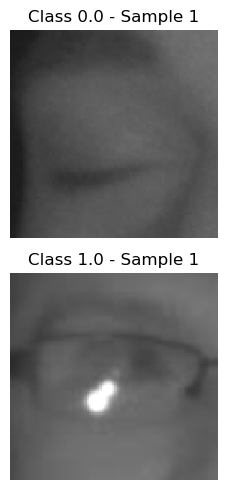

In [23]:
import matplotlib.pyplot as plt
import random

def visualize_random_images(images, labels, class_mapping, num_images=1):
    plt.figure(figsize=(10, 5))
    
    for class_label in np.unique(labels[:, 1]):
        class_indices = np.where(labels[:, 1] == class_label)[0]
        random_indices = random.sample(list(class_indices), min(num_images, len(class_indices)))
        
        for i, idx in enumerate(random_indices, start=1):
            plt.subplot(len(np.unique(labels[:, 1])), num_images, int(class_label * num_images) + i)
            plt.imshow(images[idx])
            plt.title(f"Class {class_label} - Sample {i}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_images(eye_X_train, eye_y_train, eye_label_mapping, num_images=1)


In [24]:
def calculate_image_statistics(images):
    flattened_images = images.reshape(images.shape[0], -1)

    channel_means = np.mean(flattened_images, axis=0)
    channel_stds = np.std(flattened_images, axis=0)

    return channel_means, channel_stds

channel_means_train, channel_stds_train = calculate_image_statistics(eye_X_train)

print("Image statistics for training images:")
print(f"Mean values for each channel: {channel_means_train}")
print(f"Standard deviation values for each channel: {channel_stds_train}")


Image statistics for training images:
Mean values for each channel: [ 94.7015625   98.2140625  104.85703125 ...  96.98046875 101.30859375
 109.4640625 ]
Standard deviation values for each channel: [49.4620435  50.7317651  55.70320932 ... 37.1065033  39.98074835
 48.51976359]


VGG MODEL

In [29]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(
    eye_X_train, eye_y_train, batch_size=32, shuffle=True
)

validation_generator = test_datagen.flow(
    eye_X_test, eye_y_test, batch_size=32, shuffle=False
)


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  


model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

history = model.fit(
    train_generator,
    steps_per_epoch=len(eye_X_train) // 32,
    epochs=20,  
    validation_data=validation_generator,
    validation_steps=len(eye_X_test) // 32
)
model.save('VGG_RNR_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27561282 (105.14 MB)
Trainable params: 12846594 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1

10/10 [==============================] - 39s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       160
           1       0.75      0.98      0.85       160

    accuracy                           0.83       320
   macro avg       0.86      0.83      0.82       320
weighted avg       0.86      0.83      0.82       320

Accuracy: 0.8281
Precision: 0.7512
Recall: 0.9812


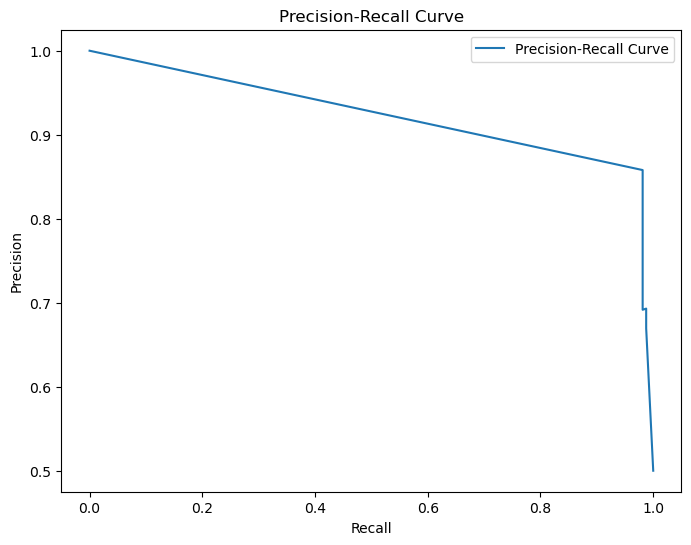

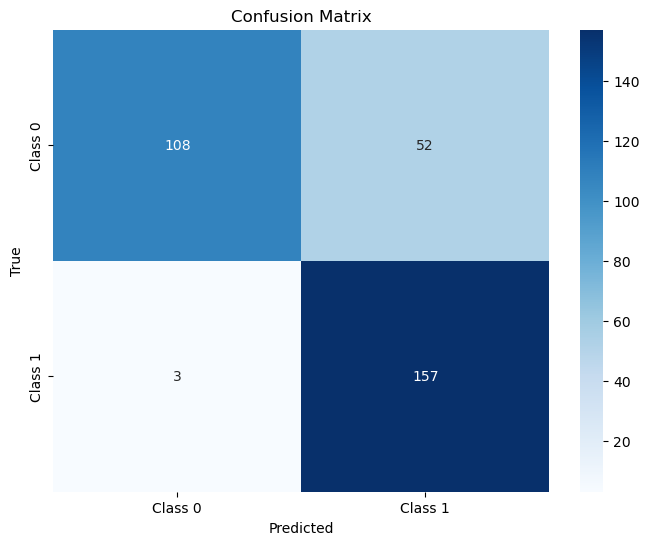

In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

model_prediction = model.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


import seaborn as sns
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


EFFICIENT NET B2

In [26]:
import warnings
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow import lite

warnings.filterwarnings("ignore")

eye_input = Input(shape=(common_shape[0], common_shape[1], 3), name='eye_input')

base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(common_shape[0], common_shape[1], 3))

eye_branch = base_model(eye_input)

eye_flatten = Flatten()(eye_branch)

eye_dropout = Dropout(0.5)(eye_flatten)

eyes_output = Dense(2, activation='softmax', name='eyes_output')(eye_dropout)

model2 = Model(inputs=eye_input, outputs=eyes_output)

model2.compile(
    optimizer=Adam(learning_rate=0.00001, beta_1=0.9),  
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

model2.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_b2_R.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6)

model_history = model2.fit(
    eye_X_train, eye_y_train,
    epochs=15,  
    batch_size=32,
    validation_data=(eye_X_test, eye_y_test),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

model2.save('Efficient_B2_R&NR_model.h5')

converter = lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eye_input (InputLayer)      [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 68992)             0         
                                                                 
 dropout (Dropout)           (None, 68992)             0         
                                                                 
 eyes_output (Dense)         (None, 2)                 137986    
                                                                 
Total params: 7906555 (30.16 MB)
Trainable params: 7838980 (29.90 MB)
Non-trainable params: 67575 (263.97 KB)
_________________

INFO:tensorflow:Assets written to: C:\Users\yashu\AppData\Local\Temp\tmp8u2487ds\assets


10/10 [==============================] - 15s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       160
           1       0.99      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy: 0.9969
Precision: 0.9938
Recall: 1.0000


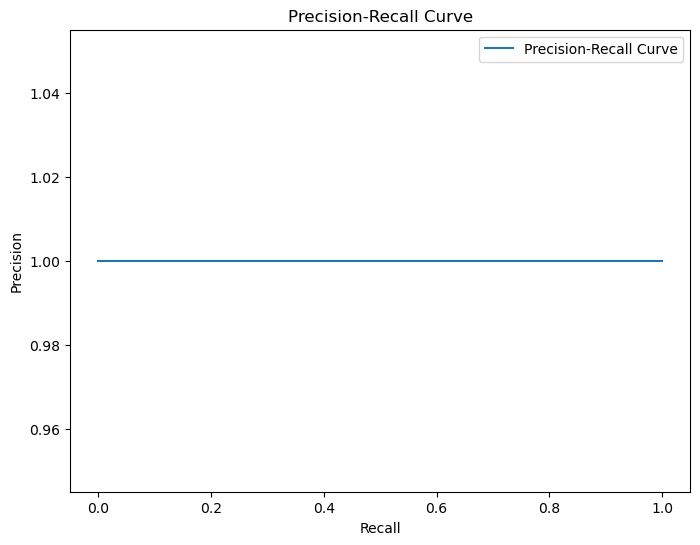

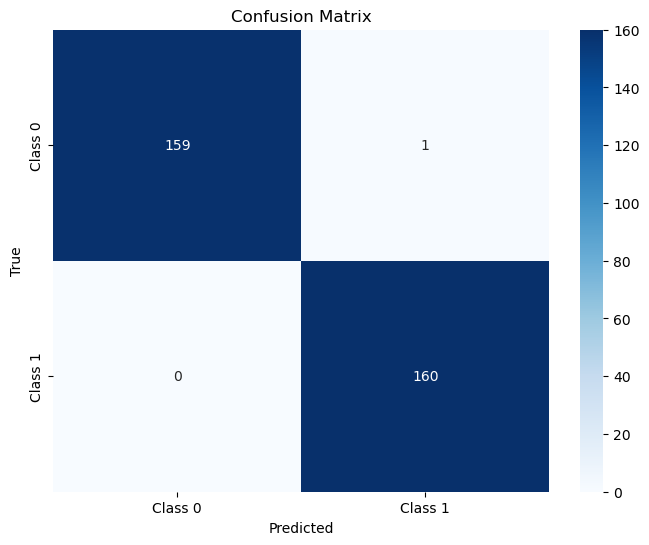

In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt

model_prediction = model2.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

customized efficientnet

In [8]:
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

warnings.filterwarnings("ignore")

def efficientnet_block(x, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)  
    return x

def efficientnet_model(input_shape, num_classes, learning_rate=0.001, momentum=0.9):
    input_tensor = Input(shape=input_shape)

    x = efficientnet_block(input_tensor, filters=32, kernel_size=(3, 3), strides=2)

    num_blocks = [1, 2, 2, 3]  
    filters = [16, 24, 40, 80] 

    for i, (blocks, filters) in enumerate(zip(num_blocks, filters)):
        for j in range(blocks):
            strides = 2 if j == 0 and i != 0 else 1
            x = efficientnet_block(x, filters=filters, kernel_size=(3, 3), strides=strides)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='efficientnet_model')

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


input_shape = common_shape
num_classes = len(eye_label_mapping)
model = efficientnet_model(input_shape, num_classes, learning_rate=0.001, momentum=0.9)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = "efficientnet_custom_R&NR_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.fit(
    datagen.flow(eye_X_train, eye_y_train, batch_size= 32),
    epochs=50,
    validation_data=(eye_X_test, eye_y_test),
    callbacks=[checkpoint, reduce_lr, lr_schedule, early_stopping]
)

loss, accuracy = model.evaluate(eye_X_test, eye_y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

best_model = tf.keras.models.load_model(checkpoint_path)




Epoch 1/50


40/40 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8797
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to efficientnet_custom_R&NR_model.h5
40/40 [==============================] - 54s 1s/step - loss: 0.3140 - accuracy: 0.8797 - val_loss: 1.2619 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9797
Epoch 2: val_accuracy improved from 0.50000 to 0.75000, saving model to efficientnet_custom_R&NR_model.h5
40/40 [==============================] - 44s 1s/step - loss: 0.1103 - accuracy: 0.9797 - val_loss: 0.4612 - val_accuracy: 0.7500 - lr: 9.0000e-04
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9844
Epoch 3: val_accuracy did not improve from 0.75000
40/40 [==============================] - 41s 1s/step - loss: 0.0612 - accuracy: 0.9844 - val_loss: 0.6142 - val_accuracy: 0.5312 - lr: 8.1000e-04
Epoch 4/50
40/40 [==

Epoch 25/50
40/40 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9969
Epoch 25: val_accuracy did not improve from 1.00000
40/40 [==============================] - 42s 1s/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 9.9391e-04 - val_accuracy: 1.0000 - lr: 7.9766e-05
Epoch 26/50
40/40 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9961
Epoch 26: val_accuracy did not improve from 1.00000
40/40 [==============================] - 44s 1s/step - loss: 0.0164 - accuracy: 0.9961 - val_loss: 0.0035 - val_accuracy: 1.0000 - lr: 7.1790e-05
Epoch 27/50
40/40 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9992
Epoch 27: val_accuracy did not improve from 1.00000
40/40 [==============================] - 44s 1s/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 1.0000 - lr: 6.4611e-05
Epoch 28/50
40/40 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9984
Epoch 28: val_accuracy

10/10 [==============================] - 2s 134ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


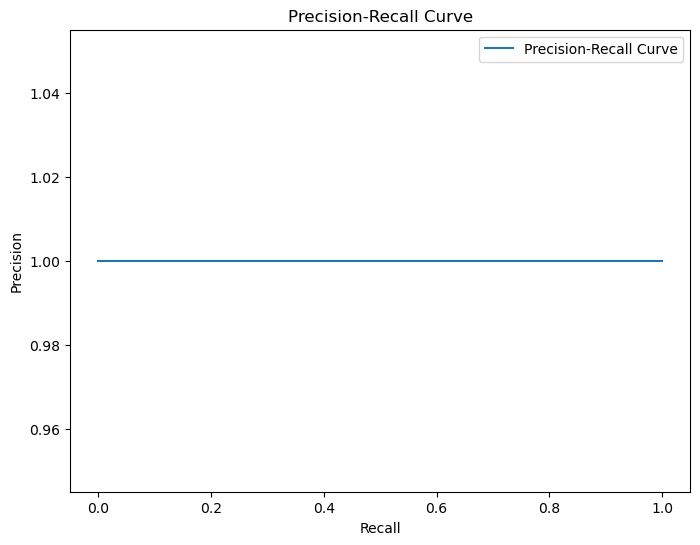

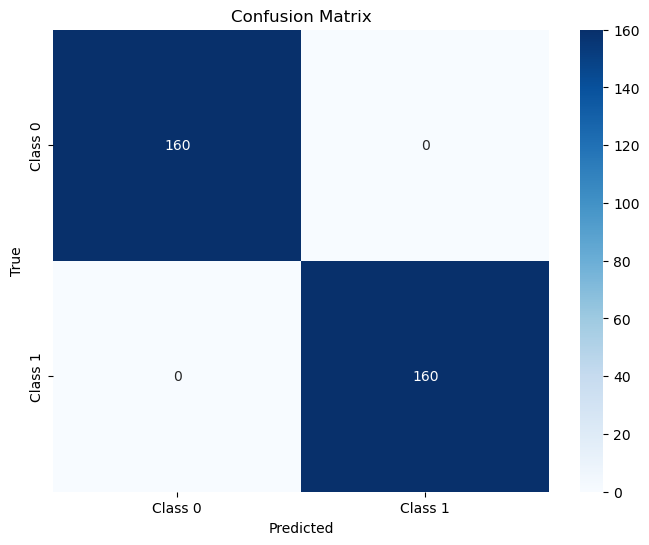

In [9]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

model_prediction = model.predict(eye_X_test)

y_true = np.argmax(eye_y_test, axis=1)
y_pred = np.argmax(model_prediction, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, model_prediction[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Determining size of the model 

In [2]:
import os

def get_model_size(file_path):
    file_size_bytes = os.path.getsize(file_path)
    
    file_size_mb = file_size_bytes / (1024 * 1024)
    
    return file_size_mb

model_paths = ['Efficient_B2_R&NR_model.h5', 'efficientnet_custom_R&NR_model.h5','VGG_RNR_model.h5']

for model_path in model_paths:
    size_mb = get_model_size(model_path)
    print(f"Size of {model_path}: {size_mb:.2f} MB")


Size of Efficient_B2_R&NR_model.h5: 91.12 MB
Size of efficientnet_custom_R&NR_model.h5: 2.26 MB
Size of VGG_RNR_model.h5: 203.22 MB


Precision plotting

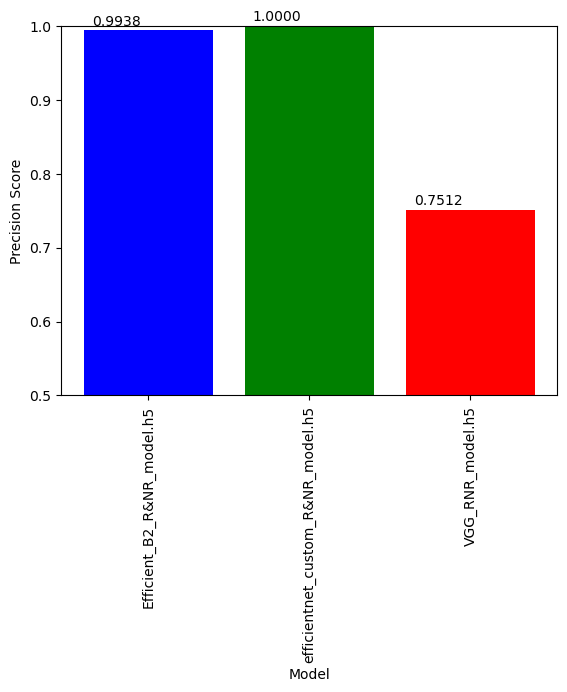

In [3]:
import matplotlib.pyplot as plt

model_names = ['Efficient_B2_R&NR_model.h5', 'efficientnet_custom_R&NR_model.h5','VGG_RNR_model.h5']
precision_values = [0.9938,1.0000,  0.7512]  
fig, ax = plt.subplots()
bars = ax.bar(model_names, precision_values, color=['blue', 'green', 'red'])

for bar, value in zip(bars, precision_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.20, bar.get_height() + 0.003, f'{value:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Precision Score')

plt.xticks(rotation=90)

plt.ylim(0.50, 1.0)  
plt.show()



Acuracy score

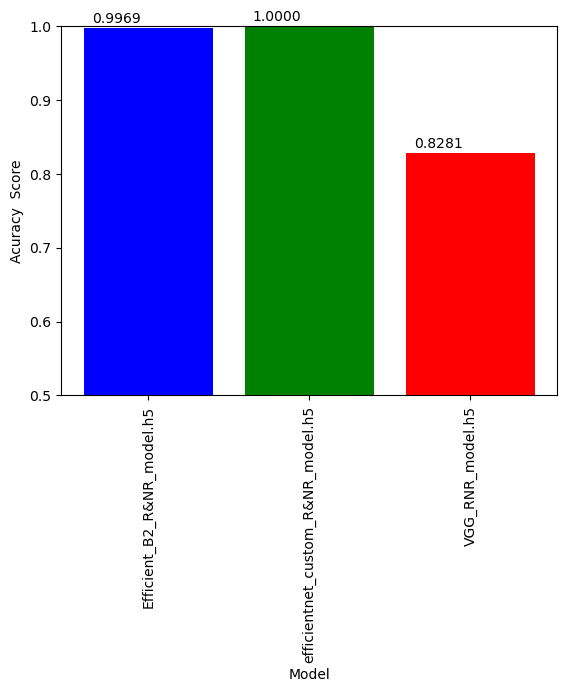

In [4]:
import matplotlib.pyplot as plt

model_names = ['Efficient_B2_R&NR_model.h5', 'efficientnet_custom_R&NR_model.h5','VGG_RNR_model.h5']
Acuracy_values = [ 0.9969, 1.0000,0.8281]  
fig, ax = plt.subplots()
bars = ax.bar(model_names, Acuracy_values, color=['blue', 'green', 'red'])

for bar, value in zip(bars,Acuracy_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.20, bar.get_height() + 0.003, f'{value:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Acuracy  Score')

plt.xticks(rotation=90)

plt.ylim(0.50, 1.0) 
plt.show()



Recall scores

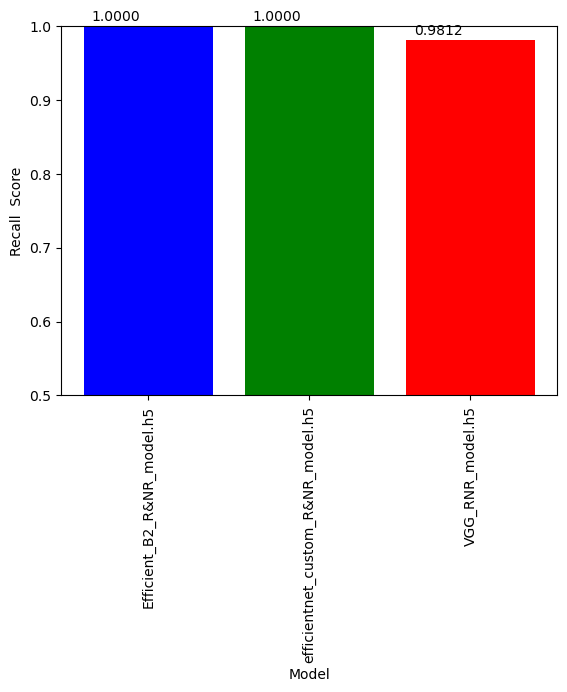

In [5]:
import matplotlib.pyplot as plt

model_names = ['Efficient_B2_R&NR_model.h5', 'efficientnet_custom_R&NR_model.h5','VGG_RNR_model.h5']
Recall_values = [ 1.0000, 1.0000, 0.9812]  

fig, ax = plt.subplots()
bars = ax.bar(model_names, Recall_values, color=['blue', 'green', 'red'])

for bar, value in zip(bars, Recall_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.20, bar.get_height() + 0.003, f'{value:.4f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Recall  Score')

plt.xticks(rotation=90)

plt.ylim(0.50, 1.0)  
plt.show()


model size ploting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


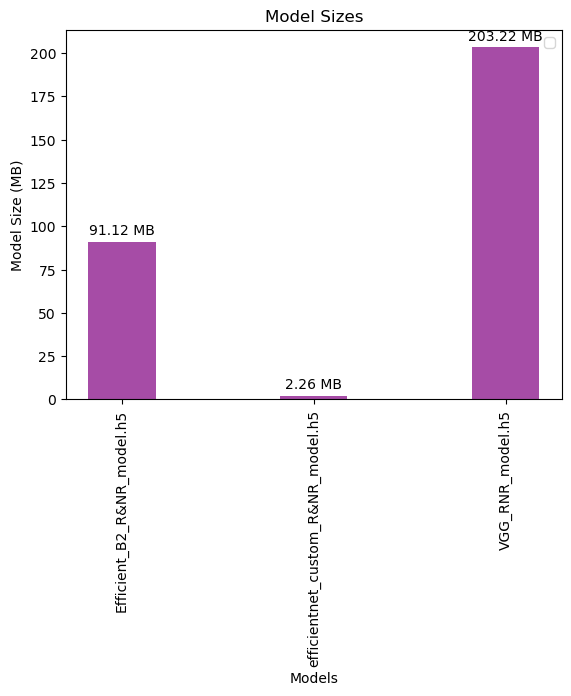

In [8]:
import os

model_paths = ['Efficient_B2_R&NR_model.h5', 'efficientnet_custom_R&NR_model.h5','VGG_RNR_model.h5']

model_sizes = [os.path.getsize(model_path) / (1024 * 1024) for model_path in model_paths]  

bar_width = 0.35

r = np.arange(len(model_paths))

fig, ax = plt.subplots()
bars = ax.bar(r, model_sizes, width=bar_width, color='purple', alpha=0.7)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f'{height:.2f} MB', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('Models')
ax.set_xticks(r)
ax.set_xticklabels(model_paths, rotation='vertical')  
ax.set_ylabel('Model Size (MB)')
ax.set_title('Model Sizes')
ax.legend()

plt.show()
